# Figure 2 
## Variance of gene expression explained by IEAs as we variate the number of IEAs.

In [1]:
import sys
sys.path.append("../../src/")
import IEA_model
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import utility

from importlib import reload 

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 

# Loading data

In [2]:
    data_train = utility.image_gene_dataset(train = True, cv = None)
    data_test = utility.image_gene_dataset(train = False, cv = None)

    train_loader = DataLoader(data_train)
    test_loader = DataLoader(data_test)


    sid_train, features_train, genes_train = data_train[:]
    sid_test, features_test, genes_test = data_test[:]

    sid_P1, features_P1 = utility.load_SSL_features_P1()
    features_P1 = torch.tensor(features_P1)
    


/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [3]:
thold = 0.01

df_genes = utility.load_gene_data()

df = pd.read_csv("../../gene_list/THOLD_{}.txt".format(thold))
idx_gene = df["index"].to_numpy()


In [4]:
def get_aligned_axes(L):
    """
    Return the aligned axes.
    L: The number of IEAs.
    """
    
    beta = .1
    gamma = 1.0
    
    
    Z_train_cv = []
    Z_test_cv = []
    Z_P1_cv = []


    M = IEA_model.IEA( L = L,  idx_gene = idx_gene ).cuda()
    # Generate the IEAs with the cross-valudation models

    for cv in range(5):
        filename = "../../models/model_L{}_cv{}_beta{}_gamma{}_genes{}".format(L, cv, beta, gamma, len(idx_gene))

        M.load_state_dict( torch.load(filename) )

        with torch.no_grad():
            _, _, _, Z_train = M.forward( features_train.cuda(), non_prb = True )
            Z_train_cv.append( Z_train.cpu().data.numpy() )

            _, _, _, Z_test = M.forward( features_test.cuda(), non_prb = True  )
            Z_test_cv.append( Z_test.cpu().data.numpy() )



    Z_train_cv = np.array( Z_train_cv )
    Z_test_cv = np.array( Z_test_cv )


    Z_test_aligned = []
    Z_train_aligned = []
    
    # Align the IEAs from models with different cross-validation.
    for cv in range(0,5):
        Z_cat = np.concatenate( [ Z_train_cv[ 0, :, : ], Z_train_cv[ cv, :, : ] ], axis = 1 )
        corrcoef = np.corrcoef(Z_cat.T)


        Z_test = []
        Z_train = []
        for lll in range(L):

            corr_lll = corrcoef[lll, L:]
            idx_lll = np.argmax( np.abs(corr_lll) )

            mean = Z_train_cv[cv, :, idx_lll].mean()
            std = Z_train_cv[cv, :, idx_lll].std()

            if corr_lll[idx_lll]>0:
                Z_train.append( ( Z_train_cv[cv, :, idx_lll] - mean ) / std  )
                Z_test.append( ( Z_test_cv[cv, :, idx_lll] - mean ) / std  )
            else:
                Z_train.append( - ( Z_train_cv[cv, :, idx_lll] - mean ) / std  )                
                Z_test.append( - ( Z_test_cv[cv, :, idx_lll] - mean) / std )

        Z_train_aligned.append( np.array(Z_train).T  )
        Z_test_aligned.append( np.array(Z_test).T )

    Z_train_aligned = np.array(Z_train_aligned)
    Z_test_aligned = np.array(Z_test_aligned)
    
    return Z_train_aligned, Z_test_aligned

In [5]:
def compute_pairwise_corrcoef(axes, idx):
    coef = np.corrcoef(axes[:, :, idx])
    coef_off_diag = np.array( [coef[iii, jjj] for iii in range(5) for jjj in range(iii)] )
    return coef_off_diag.mean(), coef_off_diag.std()

In [6]:
L_list = list(range(1, 6))
genelist = [ggg for ggg in df_genes.columns if "ENSG" in ggg]

R2_all = []
R2_selected = []

for L in L_list:
    df = pd.read_csv("../../gene_list/THOLD_{}.txt".format(thold))
    idx_gene = df["index"].to_numpy()
    res_row = [ str(thold) ]
    
    res_row.append( str(len(idx_gene)) )
    
    # Obtaining the final IEAs
    
    IEA_train, IEA_test = get_aligned_axes(L)
    
    final_IEA_train = IEA_train.sum(0)
    final_IEA_test = IEA_test.sum(0)
    
    df_IEA_train = pd.DataFrame(final_IEA_train, index = sid_train , columns = ["IEA{}".format(iii) for iii in range(L)] )
    df_IEA_test = pd.DataFrame(final_IEA_test, index = sid_test  , columns = ["IEA{}".format(iii) for iii in range(L)] )    
    
    df_IEA_genes_train = pd.merge(df_IEA_train, df_genes, left_index = True, right_index = True)
    df_IEA_genes_test = pd.merge(df_IEA_test, df_genes, left_index = True, right_index = True)    
    
    
    X_train = df_IEA_genes_train[ ["IEA{}".format(iii) for iii in range(L)] ]
    y_train = df_IEA_genes_train[ genelist ].to_numpy()
    X_test = df_IEA_genes_test[ ["IEA{}".format(iii) for iii in range(L)] ]
    y_test = df_IEA_genes_test[ genelist ].to_numpy()
    
    
    # Computing the R-squared scores for all genes
    M = LinearRegression()
    M.fit( X_train, y_train )
    R2_all.append( M.score(X_test, y_test) )

    # Computing the R-squared scores for all the selected genes
    M.fit( X_train, y_train[:, idx_gene] )
    R2_selected.append( M.score(X_test, y_test[:, idx_gene]) )
    
    

# Plotting the total variance explained for the selected genes

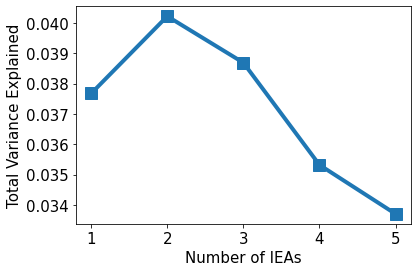

In [7]:
plt.plot(range(1, 6), R2_selected, "-s", linewidth = 4, markersize = 12)
plt.xlabel("Number of IEAs", fontsize = 15)
plt.ylabel("Total Variance Explained", fontsize = 15)
_ = plt.xticks( range(1,6), range(1,6), fontsize = 15 )
_ = plt.yticks( fontsize = 15 )

# Plotting the total variance explained for all genes

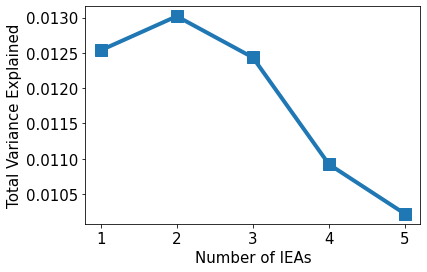

In [8]:
plt.plot(range(1, 6),  R2_all, "-s",  linewidth = 4, markersize = 12)
plt.xlabel("Number of IEAs", fontsize = 15)
plt.ylabel("Total Variance Explained", fontsize = 15)
_ = plt.xticks( range(1,6), range(1,6), fontsize = 15 )

_ = plt.yticks( fontsize = 15 )